# 置信区间绘制

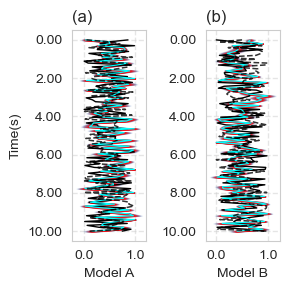

(<Figure size 300x300 with 2 Axes>,
 array([<AxesSubplot:title={'left':'(a)'}, xlabel='Model A', ylabel='Time(s)'>,
        <AxesSubplot:title={'left':'(b)'}, xlabel='Model B'>], dtype=object))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_formatter(n):
    """
    创建一个格式化器，用于格式化刻度标签。

    :param n: 小数位数
    :return: FuncFormatter 对象
    """
    return FuncFormatter(lambda value, tick_number: f'{value:.{n}f}')

def view_conf_interval(time, mmap, std, true_data=None, prior_model=None, cal_model_name=None, ylabel="Time(s)", pic_name=None, save_type=False):
    """
    绘制置信区间图，支持多个模型的对比。

    :param time: 时间数组
    :param mmap: 预测模型值数组，形状为 (时间点数, 模型数)
    :param std: 标准差数组，形状为 (时间点数, 模型数)
    :param true_data: 真实数据数组，形状为 (时间点数, 模型数)，可选
    :param prior_model: 先验模型值数组，形状为 (时间点数, 模型数)，可选
    :param cal_model_name: 模型名称列表，长度为模型数，可选
    :param ylabel: Y轴标签，默认为 "Time(s)"
    :param pic_name: 图片保存名称，可选
    :param save_type: 是否保存图片，默认为 False
    :return: fig, axs - 图形对象和子图对象
    """
    pic_num = len(cal_model_name) if cal_model_name is not None else 1  # 计算子图数量
    fig, axs = plt.subplots(1, pic_num, figsize=(1.5 * pic_num, 3))  # 创建图形和子图
    conf_width = std * 1.96  # 计算置信区间宽度
    cof_layer_num = 10  # 定义置信层的数量
    cof_layer = np.linspace(1, 0.1, cof_layer_num)  # 定义置信层的透明度变化范围

    # 如果只有一个子图，将其转换为列表以便统一处理
    if pic_num == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        for j in range(cof_layer_num):
            c_interval = cof_layer[j] * conf_width[:, i]  # 计算当前层的置信区间
            fill_color = [1 - cof_layer[j] / 1.5, cof_layer[j] / 1.5, cof_layer[j] / 1.1]  # 设置填充颜色
            ax.fill_betweenx(time, mmap[:, i] - c_interval, mmap[:, i] + c_interval, color=fill_color, alpha=0.1 * j)  # 绘制置信区间

        # 绘制真实数据（如果提供）
        if true_data is not None:
            ax.plot(true_data[:, i], time, 'k', alpha=1, lw=1, label="True")

        # 绘制预测模型值
        ax.plot(mmap[:, i], time, 'cyan', lw=0.85, label="Pred")

        # 绘制先验模型值（如果提供）
        if prior_model is not None:
            ax.plot(prior_model[:, i], time, 'k--', alpha=0.8, lw=1.1, label="Prior")

        # 设置网格线
        ax.grid(True, linestyle='--', alpha=0.5, lw=1)

        # 设置X轴标签
        ax.set_xlabel(cal_model_name[i] if cal_model_name else "Model", fontsize=10)

        # 设置标题
        ax.set_title(f"({chr(97 + i)})", loc="left", fontsize=12)

        # 反转Y轴
        ax.invert_yaxis()

        # 设置Y轴标签（仅第一个子图）
        if i == 0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_yticklabels([])  # 去除其他子图的Y轴标签

        # 设置X轴和Y轴刻度格式
        ax.xaxis.set_major_formatter(create_formatter(1))
        ax.yaxis.set_major_formatter(create_formatter(2))

    # 调整子图布局
    fig.tight_layout()

    # 保存图片（如果需要）
    if save_type and pic_name:
        plt.savefig(f"{pic_name}.png", dpi=680, bbox_inches="tight")

    # 显示图形
    plt.show()

    return fig, axs

# 示例数据
time = np.linspace(0, 10, 100)
mmap = np.random.rand(100, 2)
std = np.random.rand(100, 2) * 0.1
true_data = np.random.rand(100, 2)
prior_model = np.random.rand(100, 2)
cal_model_name = ["Model A", "Model B"]

# 调用函数
view_conf_interval(time, mmap, std, true_data=true_data, prior_model=prior_model, cal_model_name=cal_model_name, pic_name="conf_interval", save_type=True)

# 裂缝蝌蚪图

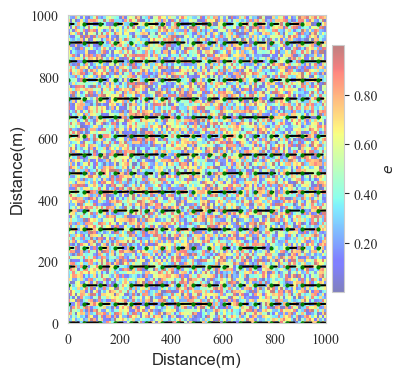

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

class CrackPlotter:
    def __init__(self, inline_set, xline_set, e, data, axis_fontdict, font_name):
        """
        初始化CrackPlotter实例。
        :param inline_set: 行内距离数组
        :param xline_set: 交叉线距离数组
        :param e: 裂缝密度分布矩阵
        :param data: 包含裂缝角度等信息的数据集
        :param axis_fontdict: 轴标签字体字典
        :param font_name: 刻度标签字体样式
        """
        self.inline_set = inline_set
        self.xline_set = xline_set
        self.e = e
        self.data = data
        self.axis_fontdict = axis_fontdict
        self.font_name = font_name
        self.fig, self.ax = plt.subplots(1, 1)
        self.fig.set_size_inches(4, 4)
        self._compute_angles_and_lengths()

    def _compute_angles_and_lengths(self):
        """计算裂缝的角度和长度"""
        self.angles = self.data[:, :, -1]
        self.lengths = (self.e - np.min(self.e)) / (np.max(self.e) - np.min(self.e)) * 60

    def create_formatter(self, decimals):
        """创建一个用于格式化颜色条标签的函数"""
        return FuncFormatter(lambda x, pos: f"{x:.{decimals}f}")

    def plot_main_figure(self):
        """绘制主图，包括背景色图和颜色条"""
        Ax = self.ax.pcolormesh(self.inline_set, self.xline_set, self.e, cmap='jet', alpha=0.5)
        self.ax.set_xlabel('Distance(m)', fontdict=self.axis_fontdict)
        self.ax.set_ylabel('Distance(m)', fontdict=self.axis_fontdict)
        cb = plt.colorbar(Ax, ax=self.ax, shrink=0.8, pad=0.02, location='right', label='$e$')
        cb.ax.yaxis.set_major_formatter(self.create_formatter(2))
        cb.ax.tick_params(labelsize=10)
        plt.setp(cb.ax.get_yticklabels(), fontproperties=self.font_name)

    def plot_crack_tadpole(self):
        """绘制裂缝蝌蚪图"""
        x_step = 6
        y_step = x_step
        for i in range(0, len(self.inline_set), x_step):
            for j in range(0, len(self.xline_set), y_step):
                angle_rad = np.radians(self.angles[j, i])
                x = [self.inline_set[i], self.inline_set[i] + self.lengths[j, i] * np.cos(angle_rad)]
                y = [self.xline_set[j], self.xline_set[j] + self.lengths[j, i] * np.sin(angle_rad)]
                self.ax.plot(x, y, 'k')  # 绘制裂缝线段
                self.ax.plot(self.inline_set[i], self.xline_set[j], marker='o', markersize=2, color='g')  # 绘制起点圆点

    def setup_plot(self):
        """设置图形的基本属性"""
        self.ax.set_ylim([self.xline_set[0], self.xline_set[-1]])
        self.ax.set_xlim([self.inline_set[0], self.inline_set[-1]])
        plt.xticks(fontproperties=self.font_name, fontsize=10)
        plt.yticks(fontproperties=self.font_name, fontsize=10)
        self.ax.plot(1881, 737, marker='*', markersize=10, color='red')  # 绘制特定位置的标记

    def show_plot(self):
        """显示图形"""
        self.plot_main_figure()
        self.plot_crack_tadpole()
        self.setup_plot()
        plt.show()

# 示例数据
inline_set = np.linspace(0, 1000, 100)  # 行内距离
xline_set = np.linspace(0, 1000, 100)  # 交叉线距离
e = np.random.rand(100, 100)  # 裂缝密度分布
data = np.random.rand(100, 100, 3)  # 包含裂缝角度等信息的数据集
axis_fontdict = {'size': 12}
font_name = {'family': 'serif'}

# 创建CrackPlotter对象并显示图形
crack_plotter = CrackPlotter(inline_set, xline_set, e, data, axis_fontdict, font_name)
crack_plotter.show_plot()